In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# create a unique ID
grid['grid_idx'] = grid['Fire_ID'].astype(str) + grid['grid_index'].astype(str)

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y  # Latitude
grid = grid.merge(df[['grid_idx','x','y']], on='grid_idx', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_idx','Fire_ID']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_idx','Fire_ID'], keep='first')


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y'],
      dtype='object')

Dropping [0] duplicate grids.



Fractional overlap:
count    57232.000000
mean         2.023404
std          2.001402
min          0.000003
25%          0.587511
50%          1.493563
75%          2.771206
max         24.470760
Name: overlap, dtype: float64



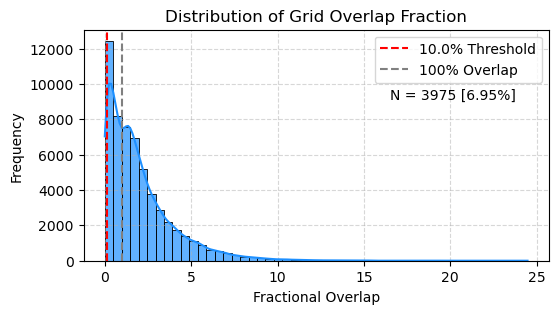

Plot saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/grid_overlap_distribution.png


In [3]:
# Check out the distribution of grid overlap with FRP observations
thresh = 0.10
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < thresh]['grid_idx'].count() 

# Plot the distribution of the fractional overlap
plt.figure(figsize=(6,3))
sns.histplot(grid['overlap'], kde=True, bins=50, color='dodgerblue', alpha=0.7)

# Add vertical line for the threshold and for 100%
plt.axvline(x=thresh, color='red', linestyle='--', label=f'{thresh*100}% Threshold')
plt.axvline(x=1, color='grey', linestyle='--', label='100% Overlap')

# Customize the plot
plt.title('Distribution of Grid Overlap Fraction')
plt.xlabel('Fractional Overlap')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(16.5, plt.ylim()[1] * 0.7, 
         f'N = {n_small} [{round(n_small/len(grid)*100,2)}%]', 
         fontsize=10, color='black')

# Save the plot
out_path = os.path.join(projdir, 'figures/grid_overlap_distribution.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {out_path}")

In [4]:
# filter out grids below the overlap threshold
print(f"Dropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with <{thresh*100}% fractional overlap.")
grid = grid[grid['overlap'] >= thresh] # remove these observations
print(len(grid))

Dropping [3975 (6.95%)] grids with <10.0% fractional overlap.
53257


In [5]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
fortyp_da = treemap_da.sel(band=2) # the fortypcd band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = fortyp_da.shape, fortyp_da.spatial_ref.GeoTransform, fortyp_da.rio.crs, fortyp_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {fortyp_da[0].dtype}")

del treemap_da # clean up
gc.collect()

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


131

In [6]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(fortyp_da), 1, 0)
# calculate the grid-level forest percent
forest_pct = compute_band_stats(grid, forest_mask, 'grid_idx', attr='forest')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
print(forest_pct.head())

forest_pct = forest_pct[forest_pct['forest'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_idx','forest_pixels','forest_pct']]

# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(grid)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")

# Save as a GeoTIFF
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask.rio.to_raster(out_fp, compress='zstd', zstd_level=9, dtype='uint16', driver='GTiff')
print(f"Saved multi-band raster to: {out_fp}")

# save the grid
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/grid_forestmask.gpkg")
grid_forest_pct = grid.merge(forest_pct, on="grid_idx", how="left")
grid_forest_pct.to_file(out_fp)
print(f"Saved grid to: {out_fp}")

del forest_mask
gc.collect() # clean up

    grid_idx  forest  count  forest_pixels  forest_pct
0  161955421       1    169            169  100.000000
1  161955422       0     15            182    8.241758
2  161955422       1    167            182   91.758242
3  161955423       0     45            169   26.627219
4  161955423       1    124            169   73.372781

[87.0%] predominantly forest grids.

    grid_idx  forest_pixels  forest_pct
0  161955421            169  100.000000
2  161955422            182   91.758242
4  161955423            169   73.372781
Saved multi-band raster to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif
Saved grid to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/grid_forestmask.gpkg


16

## Algorithmic Forest Type Code

Summary of the TreeMap Algorithmic Forest Type Code (FORTYPCD) within FRP grids. 

In [7]:
# also calculate the FORTYPCD
t0 = time.time()

# see __functions.py
grid_fortypcd = compute_band_stats(grid, fortyp_da, 'grid_idx', attr='fortypcd')

# tidy columns in the summary table
grid_fortypcd['count'] = grid_fortypcd['count'].astype(int)
grid_fortypcd['total_pixels'] = grid_fortypcd['total_pixels'].astype(int)
grid_fortypcd.rename(columns = {'count': 'fortyp_pixels'}, inplace=True)

# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df.rename(columns={
    'FORTYPCD': 'fortypcd',
    'SpeciesName': 'fortypnm'
}, inplace=True)

# join the forest name
grid_fortypcd = grid_fortypcd.merge(species_df, on='fortypcd', how='left')
print(f"\n{grid_fortypcd.head(3)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del fortyp_da, species_df # clean up 
gc.collect()


    grid_idx  fortypcd  fortyp_pixels  total_pixels  pct_cover  \
0  161955421       182              3           169   1.775148   
1  161955421       201             30           169  17.751479   
2  161955421       221              2           169   1.183432   

                 fortypnm  
0  Rocky Mountain juniper  
1             Douglas-fir  
2          Ponderosa pine  

Total elapsed time: 0.64 minutes.

~~~~~~~~~~



44

In [8]:
grid_fortypcd['fortypnm'].unique()

array(['Rocky Mountain juniper', 'Douglas-fir', 'Ponderosa pine',
       'Grand fir', 'Lodgepole pine', 'Western larch', 'Aspen',
       'White fir', 'Blue spruce', 'Western juniper',
       'California mixed conifer', 'Deciduous oak woodland', 'Nonstocked',
       'Engelmann spruce', 'Pinyon / juniper woodland', 'Subalpine fir',
       'Engelmann spruce / subalpine fir', 'Limber pine', 'Jeffrey pine',
       'Pin cherry', 'Other hardwoods', 'Intermountain maple woodland',
       'Juniper woodland', 'Foxtail pine / bristlecone pine', 'Bur oak',
       'Cercocarpus (mountain brush) woodland', 'Southwestern white pine',
       'California black oak', 'Cottonwood', 'Cottonwood / willow',
       'Sugar maple / beech / yellow birch',
       'Eastern redcedar / hardwood',
       'Sugarberry / hackberry / elm / green ash', 'Mesquite woodland',
       'Miscellaneous woodland hardwoods', 'Elm / ash / black locust',
       'Other exotic hardwoods', 'Evergreen oak woodland', 'Willow',
       'Mis



Species making up 99% of the total: 

                            fortypnm  fortyp_pixels  fraction  c_fraction
27                    Lodgepole pine        2059946  0.253768    0.253768
40                    Ponderosa pine        2017780  0.248573    0.502341
0                              Aspen         865235  0.106590    0.608931
18  Engelmann spruce / subalpine fir         793711  0.097778    0.706709
13                       Douglas-fir         472904  0.058258    0.764967
39         Pinyon / juniper woodland         381085  0.046946    0.811914
17                  Engelmann spruce         267233  0.032921    0.844834
46                     Subalpine fir         197612  0.024344    0.869179
21                         Grand fir         177132  0.021821    0.891000
53                         White fir         167809  0.020673    0.911672
43            Rocky Mountain juniper         164063  0.020211    0.931884
12            Deciduous oak woodland         159805  0.019687    0.95157

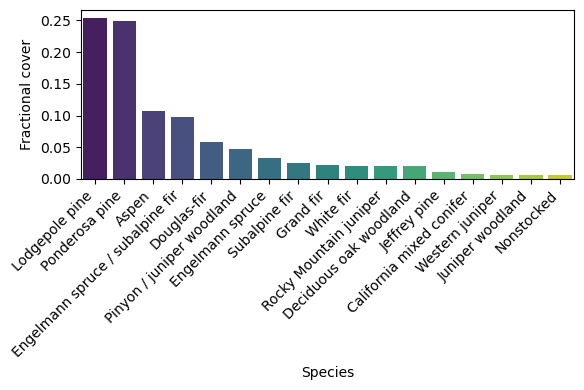

210

In [9]:
# Create a histogram of the forest species (prevalence)
fortyp = grid_fortypcd.copy() # make a copy to work with
fortyp = fortyp[fortyp['fortyp_pixels'] > 0] # make sure there are some pixels

# calculate the landscape fraction (prevalence)
spp_pr = fortyp.groupby('fortypnm')['fortyp_pixels'].sum().reset_index()
spp_pr['fraction'] = spp_pr['fortyp_pixels'] / spp_pr['fortyp_pixels'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.99]
print(f"\n\nSpecies making up 99% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='fortypnm', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# clean up
del fortyp, spp_pr
gc.collect()

In [10]:
# drop out plots with california/texas/etc. species or nonstocked
# we only want species that exist in the Southern Rockies ...
drop_spps = [
    'Jeffrey pine', 'California mixed conifer',
    'Juniper woodland', 'Western juniper',
    'Nonstocked', 'Grand fir' 
]
grid_fortypcd_ = grid_fortypcd[~grid_fortypcd['fortypnm'].isin(drop_spps)]

# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies

# Option 1
spp_grouping = {
    'pinyon / juniper woodland|rocky mountain juniper': 'Piñon-juniper',
    'engelmann spruce|subalpine fir': 'Spruce-fir',
    'ponderosa pine': 'Ponderosa', 
    'lodgepole pine': 'Lodgepole',
    'aspen': 'Quaking aspen',
    'douglas-fir|white fir': 'Mixed-conifer',
    'deciduous oak woodland': 'Oak-woodland',
    'cottonwood|willow|cottonwood / willow': 'Riparian'
}

# # Option 2
# spp_grouping = {
#     'pinyon / juniper woodland': 'Piñon-juniper',
#     'rocky Mountain juniper': 'Rocky mountain juniper',
#     'engelmann spruce|subalpine fir': 'Spruce-fir',
#     'ponderosa pine': 'Ponderosa', 
#     'lodgepole pine': 'Lodgepole',
#     'aspen': 'Quaking aspen',
#     'douglas-fir|white fir': 'Mixed-conifer',
#     'deciduous oak woodland': 'Oak-woodland',
#     'cottonwood|willow|cottonwood / willow': 'Riparian'
# }

# create the remap table
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = grid_fortypcd_[grid_fortypcd_['fortypnm'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update(
        {name: spp_group for name in spp['fortypnm'].unique()}
    )
    del spp
    
# Apply the remap to create a new grouped species column
grid_fortypcd_['fortypnm_gp'] = grid_fortypcd_['fortypnm'].map(spp_remap).fillna(grid_fortypcd_['fortypnm'])
# Verify the updated species groups
print(grid_fortypcd_[['fortypnm', 'fortypnm_gp']].drop_duplicates().head(3))
print(f"\n{grid_fortypcd_.columns}")

                 fortypnm    fortypnm_gp
0  Rocky Mountain juniper  Piñon-juniper
1             Douglas-fir  Mixed-conifer
2          Ponderosa pine      Ponderosa

Index(['grid_idx', 'fortypcd', 'fortyp_pixels', 'total_pixels', 'pct_cover',
       'fortypnm', 'fortypnm_gp'],
      dtype='object')


In [11]:
# Aggregate with the new species groupings
# Reacalculate the percent cover for each species group
grid_fortypgp = (
    grid_fortypcd_.groupby(['grid_idx','fortypnm_gp'], as_index=False)
    .agg(
        fortyp_pixels=('fortyp_pixels','sum'),
        total_pixels=('total_pixels','max'),
        fortyp_pct=('pct_cover','sum'),
    )
)

# Merge in the forest percent
grid_fortypgp = grid_fortypgp.merge(forest_pct, on='grid_idx', how='inner')
# Reclaculate the fortyp_pct
grid_fortypgp['fortyp_pct'] = grid_fortypgp['fortyp_pixels'] / grid_fortypgp['forest_pixels']

# Check on nulls introduced
print(f"\nNaNs in FORTYP group name: {grid_fortypgp['fortypnm_gp'].isna().sum()}\n")
print(f"Forest percent:\n{grid_fortypgp['forest_pct'].describe()}\n")
print(f"\n{grid_fortypgp.head(10)}\n")
print("\n~~~~~~~~~~~~~~~~~~\n")

del grid_fortypcd, grid_fortypcd_, forest_pct
gc.collect()


NaNs in FORTYP group name: 0

Forest percent:
count    228098.000000
mean         85.368331
std          23.084967
min           0.510204
25%          80.473373
50%          97.252747
75%         100.000000
max         100.000000
Name: forest_pct, dtype: float64


  grid_idx    fortypnm_gp  fortyp_pixels  total_pixels  fortyp_pct  \
0  0817469      Lodgepole              1           167    0.005917   
1  0817469  Quaking aspen            109           167    0.644970   
2  0817469     Spruce-fir             57           167    0.337278   
3  0817470  Mixed-conifer              4           178    0.021978   
4  0817470      Ponderosa              1           178    0.005495   
5  0817470  Quaking aspen            125           178    0.686813   
6  0817470     Spruce-fir             47           178    0.258242   
7  0817471  Mixed-conifer             17           158    0.100592   
8  0817471  Quaking aspen             86           158    0.508876   
9  0817471     Spruce-fir         

6430

In [12]:
# check for duplicates, remove them
n = grid_fortypgp.duplicated(subset=['grid_idx','fortypnm_gp','fortyp_pct']).sum()
if n > 0:
    print(f"\nDropping [{n}] duplicate rows.\n")
    grid_fortypgp = grid_fortypgp.drop_duplicates(subset=['grid_idx','fortypnm_gp','fortyp_pct'])
else:
    print("\nNo duplicates at this stage.\n")


No duplicates at this stage.





Species making up 97% of the total: 

      fortypnm_gp  fortyp_pixels  fraction  dom_count  dom_fraction  \
16      Lodgepole        2059946  0.269569    11112.0      0.209950   
30      Ponderosa        2017780  0.264051     9371.0      0.177055   
37     Spruce-fir        1258556  0.164697     5850.0      0.110530   
31  Quaking aspen         865235  0.113226     2537.0      0.047934   
20  Mixed-conifer         640713  0.083845     1132.0      0.021388   
29  Piñon-juniper         545148  0.071339     1355.0      0.025601   
23   Oak-woodland         159805  0.020912       20.0      0.000378   

    c_fraction  
16    0.269569  
30    0.533620  
37    0.698317  
31    0.811544  
20    0.895389  
29    0.966728  
23    0.987640  




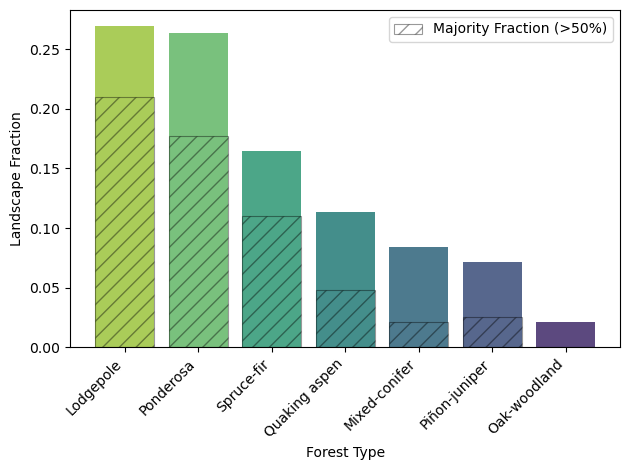

4735

In [13]:
# Re-create the histogram of forest species (prevalence)
df = grid_fortypgp.copy() # make a copy to work with
# calculate the landscape fraction (prevalence)
spp_pr = df.groupby('fortypnm_gp')['fortyp_pixels'].sum().reset_index()
spp_pr['fraction'] = spp_pr['fortyp_pixels'] / spp_pr['fortyp_pixels'].sum()

# How many grids have a majority by each species?
dom_grids = df[df['fortyp_pct'] > 0.50]  # Grids dominated by each species
dom_counts = dom_grids.groupby('fortypnm_gp')['grid_idx'].nunique().reset_index()
dom_counts.rename(columns={'grid_idx': 'dom_count'}, inplace=True)
# Total grid count for normalization
total_grids = df['grid_idx'].nunique()
dom_counts['dom_fraction'] = dom_counts['dom_count'] / total_grids

# Merge the dominance fraction into the species prevalence table
spp_pr = spp_pr.merge(dom_counts, on='fortypnm_gp', how='left').fillna(0)
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[(spp_pr['c_fraction'] <= 0.97) | (spp_pr['fraction'] > 0.01)]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# Plot the landscape fraction as bars
bar_width = 0.8
sns.barplot(
    data=top_species, 
    x='fortypnm_gp', 
    y='fraction', 
    palette='viridis_r', 
    alpha=0.9)

# Overlay the dominance fraction as cross-hatched bars
for i, species in enumerate(top_species['fortypnm_gp']):
    dom_value = top_species[top_species['fortypnm_gp'] == species]['dom_fraction'].values[0]
    plt.bar(
        x=i,
        height=dom_value,
        color='none',
        edgecolor='black',
        hatch='//',
        width=bar_width,
        alpha=0.4,
        linewidth=0.8,
        label='Majority Fraction (>50%)' if i == 0 else None,  
    )

# Add labels and formatting
plt.xlabel('Forest Type')
plt.ylabel('Landscape Fraction')
plt.xticks(ticks=range(len(top_species)), labels=top_species['fortypnm_gp'], rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()

# Save the map
out_png = os.path.join(projdir, 'figures/FigureS1_TopSpecies_97pct.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

del df, spp_pr # tidy up
gc.collect()

In [14]:
# Get the species co-occurrence percentages
spps = top_species['fortypnm_gp'].unique()
coo = get_spp_coo(grid_fortypgp, spps, grid_col='grid_idx') # see '__functions.py')
print(f"\n{coo.head(30)}\n")


Species occurrence counts:
fortypnm_gp
Ponderosa        36190
Lodgepole        34969
Quaking aspen    30165
Mixed-conifer    28923
Piñon-juniper    26461
Spruce-fir       25673
Oak-woodland     19721
Name: count, dtype: int64


                      species_pair  coo_count    coo_pct
0       (lodgepole, quaking aspen)      25262  47.733500
3       (mixed-conifer, ponderosa)      24908  47.064603
9       (piñon-juniper, ponderosa)      24463  46.223759
1          (lodgepole, spruce-fir)      22446  42.412562
12          (lodgepole, ponderosa)      21426  40.485233
13      (lodgepole, mixed-conifer)      20946  39.578255
6       (ponderosa, quaking aspen)      20829  39.357179
4   (mixed-conifer, quaking aspen)      20449  38.639155
16       (oak-woodland, ponderosa)      19048  35.991913
2      (quaking aspen, spruce-fir)      18832  35.583773
8   (mixed-conifer, piñon-juniper)      17252  32.598303
19   (oak-woodland, piñon-juniper)      16157  30.529259
15   (mixed-conifer, oak-woodl

In [15]:
# check on all the species remaining
grid_fortypgp['fortypnm_gp'].unique()

array(['Lodgepole', 'Quaking aspen', 'Spruce-fir', 'Mixed-conifer',
       'Ponderosa', 'Piñon-juniper', 'Western larch',
       'Intermountain maple woodland', 'Foxtail pine / bristlecone pine',
       'Oak-woodland', 'Southwestern white pine', 'Limber pine',
       'California black oak', 'Red alder', 'Canyon live oak',
       'Blue spruce', 'Mountain hemlock',
       'Cercocarpus (mountain brush) woodland', 'Bur oak', 'Sugar pine',
       'Miscellaneous western softwoods', 'Riparian', 'Mesquite woodland',
       'California white oak (valley oak)',
       'Sugarberry / hackberry / elm / green ash',
       'Eastern redcedar / hardwood', 'Evergreen oak woodland',
       'Balsam fir', 'Other hardwoods', 'Pin cherry',
       'Elm / ash / black locust', 'Paper birch', 'White spruce',
       'Whitebark pine', 'Western redcedar',
       'Sugar maple / beech / yellow birch', 'Red maple / upland',
       'Other exotic hardwoods', 'Sassafras / persimmon',
       'Miscellaneous woodland hardwo

In [16]:
# subset to Southern Rockies predominant species
print(f'Grids before subsetting: \n{len(grid_fortypgp)}\n')
grid_fortypgp = grid_fortypgp[grid_fortypgp['fortypnm_gp'].isin(spps)]
print(f'After:\n{len(grid_fortypgp)}\n')

Grids before subsetting: 
228098

After:
202102



## TreeMap Grid-level Canopy % and BALIVE

In [17]:
# Subset the spatial data
grid_ = grid[grid['grid_idx'].isin(grid_fortypgp['grid_idx'].unique())]
print(len(grid_))

52923


In [18]:
# Load the TreeMap Canopy % 
canopypct = os.path.join(projdir, "data/spatial/raw/USFS/TreeMap/treemap_west_canopypct.tif") 
canopypct = rxr.open_rasterio(canopypct, masked=True, cache=False).squeeze()
# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = canopypct.shape, canopypct.spatial_ref.GeoTransform, canopypct.rio.crs, canopypct.rio.nodata
print(
    f"\nShape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {canopypct[0].dtype}\n")

# Calculate the mean grid-level canopy percent
canopypct_mn = compute_band_stats(
    geoms=grid_, 
    image_da=canopypct, 
    id_col='grid_idx', 
    attr='canopypct', 
    stats=['mean'], # calculate the mean canopy pct
    ztype='continuous'
)
canopypct_mn.head()


Shape: (72854, 61899); 
GeoTransform: -2361585.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32



,grid_idx,canopypct_mean
0,161955421,66.526627
1,161955422,45.904192
2,161955423,45.532258
3,161957669,58.384615
4,161957670,60.295918


In [19]:
# Load the TreeMap BALIVE
balive = os.path.join(projdir, "data/spatial/raw/USFS/TreeMap/treemap_west_balive.tif") 
balive = rxr.open_rasterio(balive, masked=True, cache=False).squeeze()
# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = balive.shape, balive.spatial_ref.GeoTransform, balive.rio.crs, balive.rio.nodata
print(
    f"\nShape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {balive[0].dtype}\n")

# Calculate the mean grid-level canopy percent
balive_sum = compute_band_stats(
    geoms=grid_, 
    image_da=balive, 
    id_col='grid_idx', 
    attr='balive', 
    stats=['sum'],
    ztype='continuous'
)

# Merge the canopy percent and BALIVE
grid_metrics = pd.merge(canopypct_mn, balive_sum, on="grid_idx", how="inner")
print(grid_metrics.head())

# Merge to the forest type dataframe
grid_fortypgp = pd.merge(grid_fortypgp, grid_metrics, on="grid_idx", how="left")
print(f"\n{grid_fortypgp.columns}\n")


Shape: (72854, 61899); 
GeoTransform: -2361585.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32

    grid_idx  canopypct_mean    balive_sum
0  161955421       66.526627  20983.164062
1  161955422       45.904192  16590.960938
2  161955423       45.532258  10508.059570
3  161957669       58.384615  22925.648438
4  161957670       60.295918  27245.277344

Index(['grid_idx', 'fortypnm_gp', 'fortyp_pixels', 'total_pixels',
       'fortyp_pct', 'forest_pixels', 'forest_pct', 'canopypct_mean',
       'balive_sum'],
      dtype='object')



In [20]:
# save the TreeMap FORTYPCD table out.
out_fp = os.path.join(projdir,'data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypnm_gp.csv')
grid_fortypgp[[
    'grid_idx', 'fortypnm_gp', 'fortyp_pct', 
    'canopypct_mean', 'balive_sum', 'forest_pct'
]]
grid_fortypgp.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypnm_gp.csv


In [21]:
grid_fortypgp[['fortyp_pct','canopypct_mean','balive_sum']].head()

,fortyp_pct,canopypct_mean,balive_sum
0,0.005917,51.215569,17375.951172
1,0.644970,51.215569,17375.951172
2,0.337278,51.215569,17375.951172
3,0.021978,53.404494,19866.035156
4,0.005495,53.404494,19866.035156


In [ ]:
# subset the grids to predominantly forested plots (>50% forested)
# Just work with forested grids from here on out:
grid_forest = grid_fortypgp[grid_fortypgp['forest_pct'] > 50]
n_forest = len(grid_forest['grid_index'].unique())
print(f"{n_forest}/{len(grid)} [{round(n_forest/len(grid)*100,1)}%] gridcells are >50% forested.")

In [ ]:
# plot the distribution of percent cover by forest types
df = grid_fortypgp.copy()
df['fortypnm_gp'] = df['fortypnm_gp'].astype('category')
species_order = top_species['fortypnm_gp'].tolist()
df['fortypnm_gp'] = pd.Categorical(
    df['fortypnm_gp'],
    categories=species_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=df,
    col='fortypnm_gp',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'pct_cover', fill=True, alpha=0.6)
# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Percent Cover (%)", "Density", size=8)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

del df
gc.collect()

plt.show()

In [ ]:
grid_fortypgp.columns

In [ ]:
grid_fortypgp['fortypnm_gp'].isna().sum()

In [ ]:
print(len(grid_fortypgp))
print(len(grid))

In [ ]:
# join the forest type dataframe to our FRP gridcells
grid_frp = grid.merge(grid_fortypgp, on='grid_index', how='inner')
print(grid_frp.columns)
print(len(grid_frp))

# tidy up
del grid_forest
gc.collect()

In [ ]:
print(f"\nDropping [{grid_frp['fortypnm_gp'].isna().sum()}] NaN rows.\n")
grid_frp = grid_frp[~grid_frp['fortypnm_gp'].isna()]
print(len(grid_frp))

In [ ]:
print(f"\nSubsetting to top species groups:\n{top_species['fortypnm_gp'].unique()}")
grid_frp = grid_frp[grid_frp['fortypnm_gp'].isin(top_species['fortypnm_gp'].unique())]
print(f"\n{len(grid_frp['grid_index'].unique())}/{len(grid['grid_index'].unique())}")

In [ ]:
# make some plots showing the distribution of FRP across forest types
# gather the dominant forest type
dfortyp = grid_frp.loc[grid_frp.groupby('grid_index')['pct_cover'].idxmax()]
print(dfortyp['fortypnm_gp'].unique())
print("\n")

# Retain only the daytime FRP measurements
n_small = len(dfortyp[dfortyp['frp_max_day'] == 0]) 
print(f"Dropping {n_small} [{round(n_small/len(dfortyp)*100,1)}%] gridcells w/ >0 max daytime FRP.")
dfortyp = dfortyp[(dfortyp['frp_max_day'] > 0)]

# create a dataframe with dominance (>90% of the same species)
dom = dfortyp[dfortyp['pct_cover'] > 50]
# Plot FRP by dominant forest type
# Find the median and sort the forest types by FRP
med = dom.groupby('fortypnm_gp')['frp_max_day'].median().sort_values(ascending=False)
sorted = med.index.tolist()

# setup the plot
plt.figure(figsize=(6, 4)) 

# boxplot
sns.boxplot(
    data=dom, 
    x='frp_max_day', 
    y='fortypnm_gp', 
    order=sorted, 
    palette='coolwarm_r', 
    fliersize=4,
    dodge=False)

# adjust plot elements
plt.xscale('log') # log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type')
plt.tight_layout()
# save it out.
out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

In [ ]:
# Run a statistical test between these groups
from scipy.stats import kruskal
import scikit_posthocs as sp

# Group FRP by forest type
grouped_frp = [dom[dom['fortypnm_gp'] == f]['frp_max_day'].values for f in sorted]
# Perform Kruskal-Wallis test
stat, p = kruskal(*grouped_frp)
print(f"\nKruskal-Wallis Test: H={stat:.3f}, p={p:.3e}\n")

# Dunn's test for pairwise comparisons
dunn = sp.posthoc_dunn(
    dom, val_col='frp_max_day', group_col='fortypnm_gp', p_adjust='bonferroni'
)
print(f"Dunn's test:\n{dunn}")
print("\n~~~~~~~~~~~~~~~~~\n")

del grouped_frp, stat, p, dunn
gc.collect()

In [ ]:
# Plot the Day vs. Night max FRP for dominant types
dom = dom[dom['frp_max_day'] > 0]
dom = dom[dom['frp_max_night'] > 0]

# Reshape the data to long format for both day and night FRP
dom_l = pd.melt(
    dom, 
    id_vars=['fortypnm_gp'], 
    value_vars=['frp_max_day', 'frp_max_night'], 
    var_name='DayNight', 
    value_name='FRP'
)

# Map `Time` values for clearer labels
dom_l['DayNight'] = dom_l['DayNight'].map({
    'frp_max_day': 'Day', 
    'frp_max_night': 'Night'
})

# Create the plot
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=dom_l,
    x="FRP",
    y="fortypnm_gp",
    hue="DayNight",
    order=sorted,
    palette='magma_r',
    fliersize=3,
)

plt.xscale('log')  # Log-scale FRP
plt.xlabel('Fire Radiative Power (FRP)', fontsize=11)
plt.ylabel('Forest Type', fontsize=11)
plt.legend(title='', loc='lower right', fontsize=9)
plt.tight_layout()

# Save and show the plot
out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_DayNight_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved to: {out_plot}\n")

In [ ]:
# save the table out.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_fortypnm_gp_forest_frp.csv')
grid_frp.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

In [ ]:
# Identify gridcells with some aspen component
aspen_idx = grid_frp[grid_frp['fortypnm_gp'] == 'Quaking aspen']['grid_index'].unique() # list of grid indices
grid_aspen = grid_frp[grid_frp['grid_index'].isin(aspen_idx)]
# check how many aspen gridcells there are
n_aspen = len(grid_aspen['grid_index'].unique())
print(f"{n_aspen} [{round(n_aspen/len(grid_frp['grid_index'].unique())*100,1)}%] gridcells with some aspen component.")

In [ ]:
# waffle chart version
# create bins for species composition
bins = np.linspace(0, 100, 6) # 20% intervals
spps = [s for s in grid_aspen['fortypnm_gp'].unique() if s != 'Quaking aspen'] # exclude aspen from species list
print(f"Associate forest type: {spps}\n")

# create grid data
df = grid_aspen.copy() # work from a copy
tiles = []  # Store tile data
for sp in spps:
    # Filter for co-occurrence
    df_sp = df[df['fortypnm_gp'].isin(['Quaking aspen', sp])]
    # Pivot to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(
            index='grid_index', 
            columns='fortypnm_gp', 
            values='pct_cover', 
            fill_value=0
        ).reset_index()
         .rename(columns={'Quaking aspen': 'aspen_cover', sp: f'{sp}_cover'})
    )
    # Make sure there are some of each species (aspen and other)
    cover_df['combined_cover'] = cover_df['aspen_cover'] + cover_df[f'{sp}_cover']
    cover_df = cover_df[cover_df['combined_cover'] >= 50] # where one or both make up the majority
    # Merge back with FRP data
    cover_df = cover_df.merge(
        grid_aspen[['grid_index','frp_max_day', 'frp_max_night']].drop_duplicates(), 
        on='grid_index', how='left')

    # Bin Aspen and species percent cover
    cover_df['aspen_bin'] = pd.cut(cover_df['aspen_cover'], bins, labels=range(len(bins) - 1))
    cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_cover'], bins, labels=range(len(bins) - 1))
    # Group by bins and calculate statistics
    grouped = cover_df.groupby(['aspen_bin', f'{sp}_bin'])
    counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
    mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

    # Merge statistics into a single DataFrame
    tiled_data = pd.merge(counts, mean_frp, on=['aspen_bin', f'{sp}_bin'])
    tiled_data['species'] = sp
    tiles.append(tiled_data)

    # Tidy up
    del df_sp, cover_df, grouped, counts, mean_frp, tiled_data
    gc.collect()

# Combine tile data
tiles_df = pd.concat(tiles, ignore_index=True)
tiles_df['log_frp'] = np.log10(tiles_df['frp'] + 1e-6) # add a small value to help with log-scaling

# Normalize tile sizes (scale frequency)
tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2  # Square root scaling for better size balance

# Plotting the tile-scaled heatmap
n_cols = 3  # Number of columns in the facet grid
n_rows = int(np.ceil(len(spps) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,6), constrained_layout=True)
axes = axes.flatten()

# handle the normalization
vmin = tiles_df['log_frp'].min()
vmax = tiles_df['log_frp'].quantile()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Define color normalization based on raw FRP range

# log_frp_min = np.percentile(tiles_df['log_frp'], 10)
# log_frp_max = np.percentile(tiles_df['log_frp'], 90)

# make the grids
for i, sp in enumerate(spps):
    sp_data = tiles_df[tiles_df['species'] == sp]
    ax = axes[i]

    vmin = sp_data['frp'].min()
    vmax = sp_data['frp'].max()

    for _, row in sp_data.iterrows():
        x = int(row[f'{sp}_bin'])  
        y = int(row['aspen_bin'])  
        size = row['tile_size'] * 0.9
        
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        color = plt.cm.coolwarm(norm(row['frp']))
        
        ax.add_patch(
            plt.Rectangle(
                (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
            )
        )

    # Formatting the axes
    # ax.set_title(sp, size=10)
    ax.text(
        0.95, 0.95, sp,  # x, y position in axis coordinates (top-right corner)
        transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
        ha='right', va='top',  # Align the text to the top-right
        fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
    )
    ax.set_xlabel(f'')
    ax.set_ylabel('Aspen Cover (%)', size=9)
    ax.set_xticks(range(len(bins) - 1))
    ax.set_yticks(range(len(bins) - 1))
    ax.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_xlim(-0.5, len(bins) - 1.5)
    ax.set_ylim(-0.5, len(bins) - 1.5)

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('Maximum FRP')
# cbar.set_label('Cumulative FRP', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

del df

out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_FRPmax_Scaled_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
gc.collect()